## TM3 [DW] : REFIT House 2 to REFIT House 6

Transfer Learining model by parameter sharing from REFIT house 2 to REFIT house 6 , appliance: Dish washer
Cited paper:

@inproceedings{ahmed2020generative,
  title={Generative Adversarial Networks and Transfer Learning for Non-Intrusive Load Monitoring in Smart Grids},
  author={Ahmed, Awadelrahman MA and Zhang, Yan and Eliassen, Frank},
  booktitle={2020 IEEE International Conference on Communications, Control, and Computing Technologies for Smart Grids (SmartGridComm)},
  pages={1--7},
  year={2020},
  organization={IEEE}
}

In [1]:
import os
import numpy as np
import math

import torchvision.transforms as transforms
from torchvision.utils import save_image

from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler as standarize_data
from sklearn.preprocessing import MinMaxScaler as scale_data
from sklearn.utils import shuffle

plt.style.use('bmh')


### parameters and configuration

In [2]:
sig_len=800
lr=0.000002 #0.00002
b1=0.5
b2=0.999
n_epochs=1000
batch_size=1024
s=2
sample_interval=500

cuda = True if torch.cuda.is_available() else False

FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor




## loading, downsampling and scaling data

In [3]:
X_train=np.load("data/REFIT_house6_X_train_segments_DW.npy")
Y_train=np.load("data/REFIT_house6_Y_train_segments_DW.npy")

# choosing only 10% of the source dataset
seg=int(0.1*len(X_train))
print(seg)
X_train=X_train[:seg,:]
Y_train=Y_train[:seg,:]

X_train[X_train<=50] = 0
Y_train[Y_train<=50] = 0

scale_agg=scale_data()
scale_app=scale_data()

scale_agg.fit(X_train)
scale_app.fit(Y_train)
X_train_n=scale_agg.transform(X_train)
Y_train_n=scale_app.transform(Y_train)


4585


/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


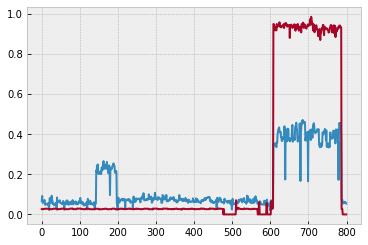

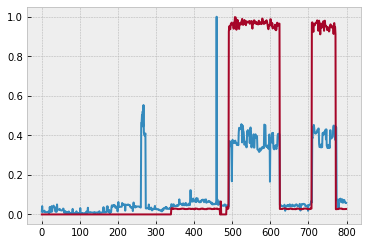

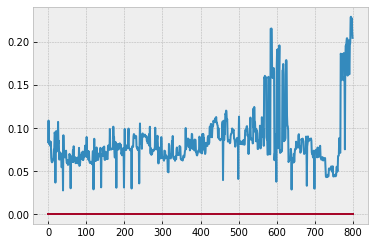

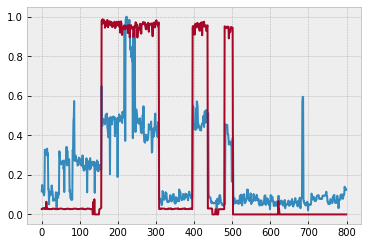

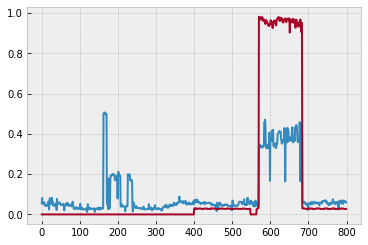

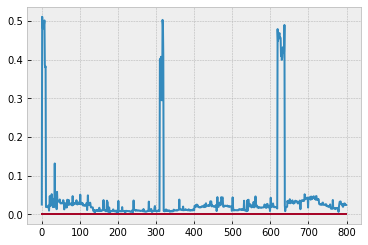

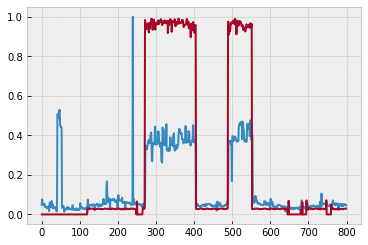

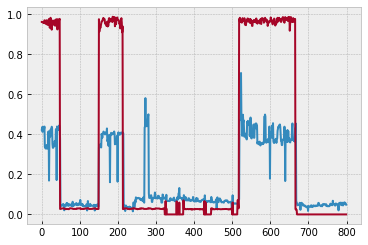

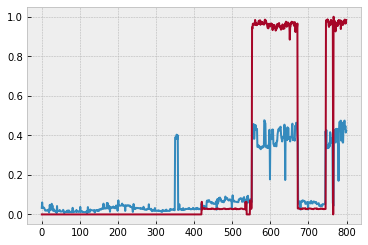

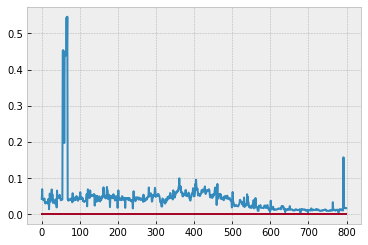

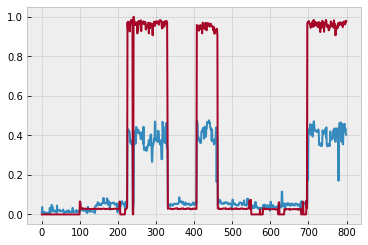

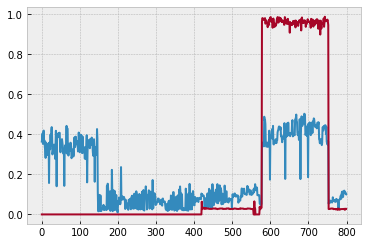

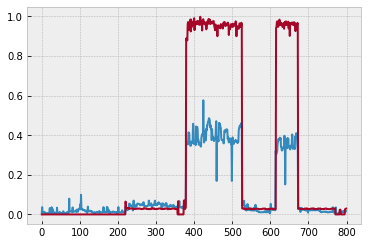

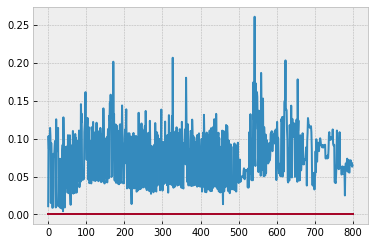

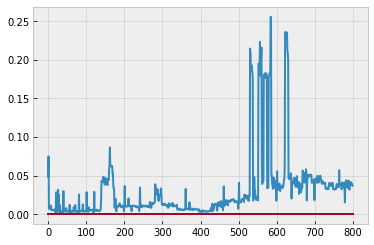

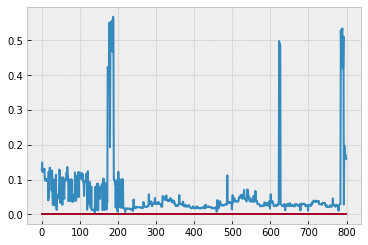

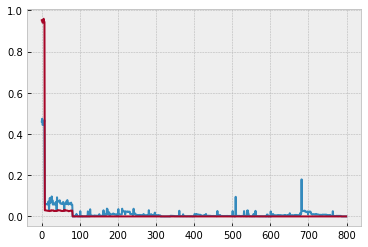

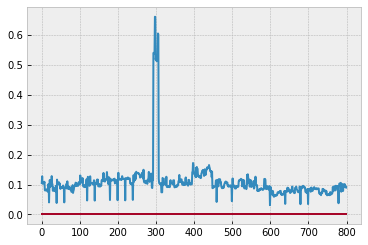

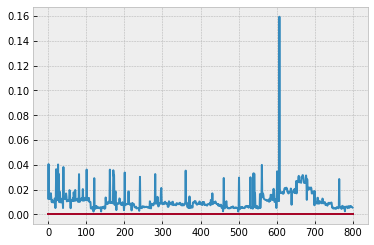

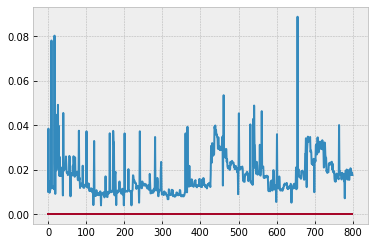

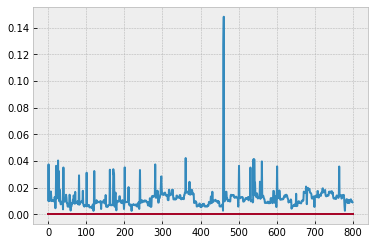

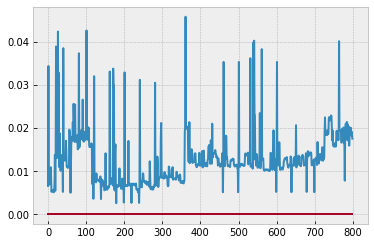

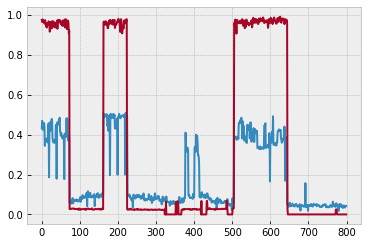

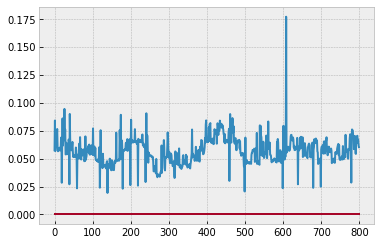

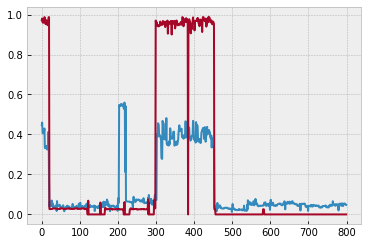

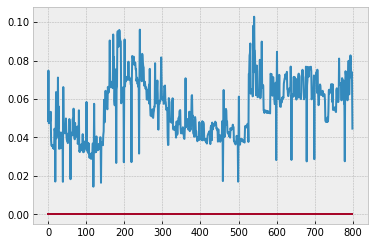

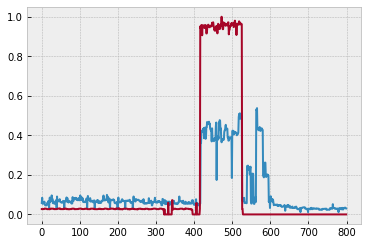

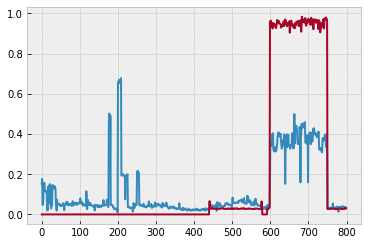

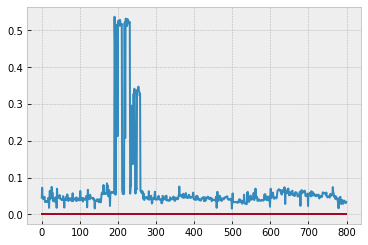

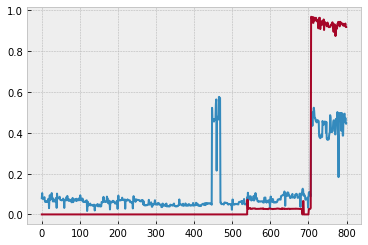

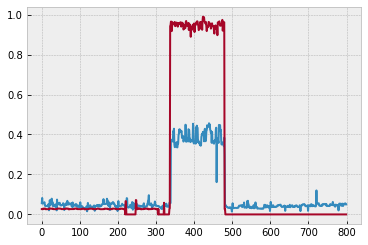

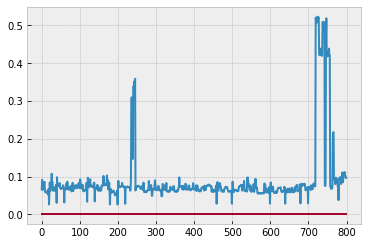

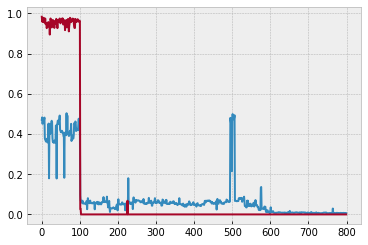

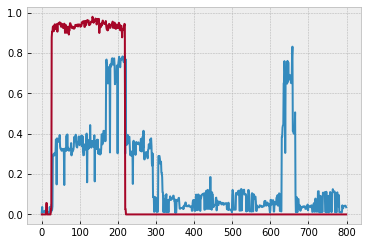

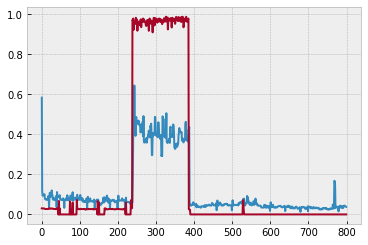

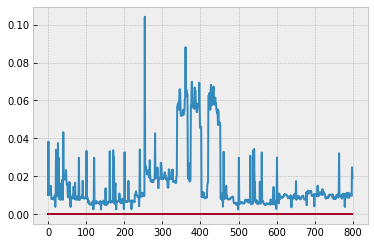

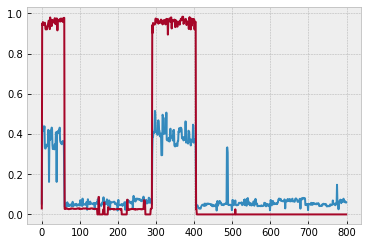

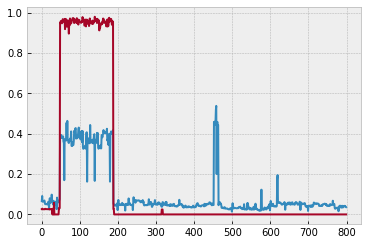

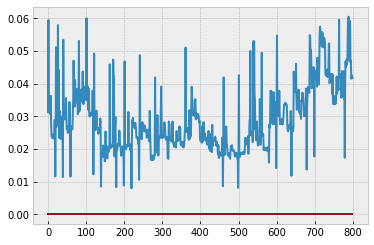

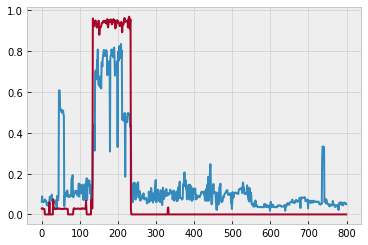

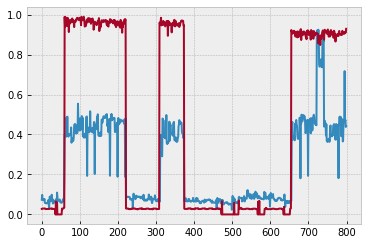

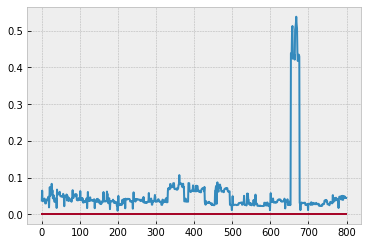

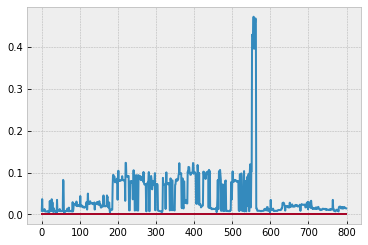

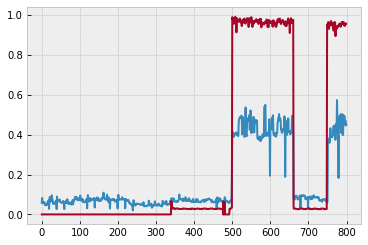

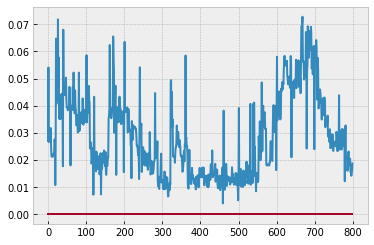

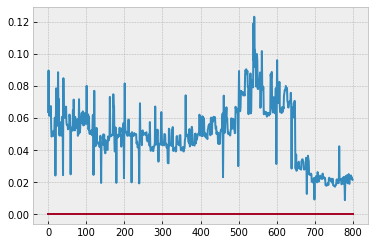

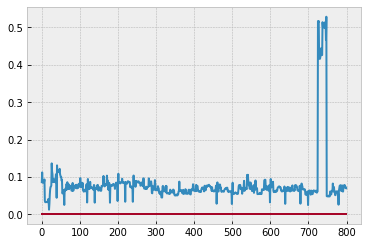

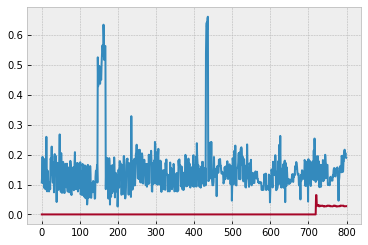

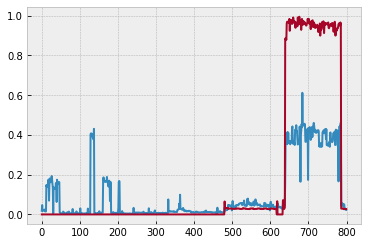

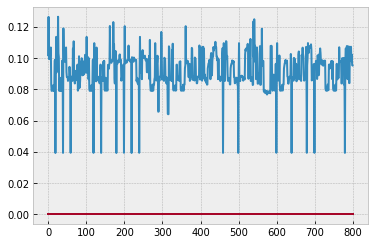

(4585, 800)

In [4]:
for i in range(50):
    plt.plot(X_train_n[i,:])
    plt.plot(Y_train_n[i,:])
    plt.show()
X_train.shape

## GANNILM Classes

In [5]:
class Swish(torch.nn.Module):
    def forward(self,x):
        return x * torch.sigmoid(x)


class Flatten(torch.nn.Module):
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)

    
class Projection(torch.nn.Module):
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size,projection,-1) #bsize, projection,length

class Generator(nn.Module):
    def __init__(self):
        super().__init__()


        def block(in_feat, out_feat, normalize=False):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.9))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        
        def conv(in_feat, out_feat, filter_size=5, stride=1,padding=True):
            if padding==True: 
                p=int((filter_size-1)/2)
            else:
                p=0
            conv_layers = [nn.Conv1d(in_feat, out_feat,filter_size,stride,padding=p)]
            conv_layers.append(nn.LeakyReLU(0.2, inplace=True))
            return conv_layers

        def flat():
            flatten=Flatten()
            layers = [flatten]
            #layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        
        def swish():
            s=Swish()
            layers = [s]
            #layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        
        def project():
            project_layer=Projection()
            layers = [project_layer]
            #layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        
        
        h=8 # hidden layer neurons multiple of signal length
        f=2 #output featrue maps
        
        self.g1 = nn.Sequential(
            *conv(in_feat=1,out_feat=f*2,filter_size=5,stride=1,padding=True),
            

        )
        
        self.g2 = nn.Sequential(
            *conv(in_feat=f*2,out_feat=f*3,filter_size=5,stride=1,padding=True),
            *flat(),
        )
        
        self.g3 = nn.Sequential(
            *block(sig_len*f*3, int(sig_len*f*4), normalize=False),

        )
        
        
        self.g4 = nn.Sequential(
            *block(int(sig_len*f*4), int(sig_len*f*6)),

        )
        
        
        
        
        self.g5 = nn.Sequential(
            
            *block(int(sig_len*f*6), int(sig_len*f*4)),

        )
        
         
        self.g6 = nn.Sequential(
            
            *block(int(sig_len*f*4), int(sig_len*f*3)),

        )
        
        self.g7 = nn.Sequential(
            
            nn.Linear(int(sig_len*f*3), int(np.prod(sig_len))),
#           nn.ReLU() #tanh
            nn.LeakyReLU(0.01, inplace=True) #tanh
        )

    #def forward(self, noise, labels):
    def forward(self,aggregate):
        # Concatenate label embedding and image to produce input
        X = self.g1(aggregate)
        X = self.g2(X)
        X = self.g3(X)
        X = self.g4(X)
        X = self.g5(X)
        X = self.g6(X)
        appliance = self.g7(X)
        return appliance

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()


        d=4
        
        def conv(in_feat, out_feat, filter_size=5, stride=1,padding=True):
            if padding==True: 
                p=int((filter_size-1)/2)
            else:
                p=0
            conv_layers = [nn.Conv1d(in_feat, out_feat,filter_size,stride,padding=p)]
            conv_layers.append(nn.LeakyReLU(0.2, inplace=True))
            return conv_layers
        
        def flat():
            flatten=Flatten()
            layers = [flatten]
            #layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        
        f=2
        self.d1 = nn.Sequential(
            nn.Linear(int(sig_len*2), sig_len*d),
#             nn.Linear(int(sig_len*2*f*1), sig_len*d),
            nn.LeakyReLU(0.2, inplace=True),
            
            
        )
        
        self.d2 = nn.Sequential(
            nn.Linear(sig_len*d, sig_len*d),
            #nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
 
            
        )
        
        self.d3 = nn.Sequential(
            
            nn.Linear(sig_len*d, sig_len*d),
            #nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            
            
        )
        
        self.d4 = nn.Sequential(

            nn.Linear(sig_len*d, sig_len*2),
            #nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            
        )
        
        
        self.d5 = nn.Sequential(
            
            nn.Linear(sig_len*2, 1),
            nn.Sigmoid(),

        )
        
        

    def forward(self, d_input):
        X=self.d1(d_input)
        X=self.d2(X)
        X=self.d3(X)
        features=self.d4(X)
        validity = self.d5(features)
        
        return validity,features


In [7]:
class data_it(Dataset):
    def __init__(self):
   
        self.len=X_train_n.shape[0]
        self.xdata=torch.from_numpy(X_train_n)
        self.ydata=torch.from_numpy(Y_train_n)
        
    def __getitem__(self,index):
        return (self.xdata[index],self.ydata[index])
    
    def __len__(self):
        return(self.len)


## Loss Definition and instantiation

In [8]:
feature_loss=torch.nn.MSELoss()
# adversarial_loss = torch.nn.MSELoss()
adversarial_loss = torch.nn.BCELoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()



## Loading Model

In [9]:
PATH="saved_models/REFIT_house2_DW.pth"
checkpoint = torch.load(PATH)
generator.load_state_dict(checkpoint['g_state_dict'],strict=True)
discriminator.load_state_dict(checkpoint['d_state_dict'],strict=True)

## Utility Functions

In [10]:

def smooth(y, box_pts=10):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth


def down_sample(X,Y,s):
    #X=X.reshape(X.shape[0],X.shape[1])
    Y=Y.reshape(Y.shape[0],Y.shape[1])
    Y_s=Y[:, ::s]
    X_s=X[:,::s]
    dim=X_s.shape[1]
    return(X_s,Y_s.reshape(-1,dim))


def sample_data(n_row, batches_done):
    
    a_to_s=X_train_n[0:10,:] # z
    agg_to_sample=a_to_s.reshape(a_to_s.shape[0],1,a_to_s.shape[1])
    
    true_app=Y_train_n[0:10,:]

    agg_to_sample = Variable(FloatTensor(agg_to_sample))
    gen_ds = generator(agg_to_sample)
    
    
    gen_ds_inv=scale_app.inverse_transform(gen_ds.cpu().detach())
    true_app_inv=scale_app.inverse_transform(true_app)
    

    plt.plot(smooth(gen_ds_inv[1,:]),label="GAN")
    plt.plot(true_app_inv[1,:],label="Real")
    plt.legend()
    plt.show()

    plt.plot(smooth(gen_ds_inv[2,:]),label="GAN")
    plt.plot(true_app_inv[2,:],label="real")
    plt.legend()
    plt.show()


    
    

def disaggregate(x):
    x = Variable(FloatTensor(x))
    gen_appliance = generator(x)
    return (gen_appliance)

def confidence(appliance,aggregate):
    agg=Variable(FloatTensor(aggregate))
    d_in=torch.cat((appliance,agg),1)
    conf,_=discriminator(d_in)
    return(conf)


   
def classification_metrics(pred1, real_measurements1,thresh):
#    real_measurements
#    pred=predictions
    
    pred=np.copy(pred1)
    real_measurements=np.copy(real_measurements1)
    on_threshold=thresh
    pred[pred <=on_threshold] = 0
    pred[pred >on_threshold] = 1
    
#     plt.plot(pred)
#     plt.show()
    
    real_measurements[real_measurements <=on_threshold] = 0
    real_measurements[real_measurements >on_threshold] = 1
#     plt.plot(real_measurements)
#     plt.show()


    #print("calculating metrics...TP")
    TP=np.sum(np.logical_and(pred == 1, real_measurements == 1))
#     print("TP=",TP)
    #print("calculating metrics...FP")
    FP=np.sum(np.logical_and(pred == 1, real_measurements == 0))
#     print("FP=",FP)

    #print("calculating metrics...FN")
    FN=np.sum(np.logical_and(pred == 0, real_measurements == 1))
    #print("calculating metrics...TN")
    TN=np.sum(np.logical_and(pred == 0, real_measurements == 0))
    P=sum(real_measurements)
    N=len(real_measurements)-sum(real_measurements)
    
    recall=TP/(TP+FN)
    precision=TP/(TP+FP)
    F1=2*(precision*recall)/(precision+recall)
    accuracy=(TP+TN)/(P+N)
    
    return(recall,precision,F1,accuracy)
    
    
    

def energy_metrics(pred1, real_measurements1,thresh):
    
    
    pred=np.copy(pred1)
    real_measurements=np.copy(real_measurements1)
    on_threshold=thresh
    pred[pred <=on_threshold] = 0
    real_measurements[real_measurements <=on_threshold] = 0

    #pred[pred >on_threshold] = 1
    
    E=np.sum(real_measurements)
    E_hat=np.sum(pred)
    RE=(E_hat-E)/(max(E,E_hat))
#     RE=(E_hat-E)/(E)
    T=len(pred)
    MAE=(1/T)*sum(np.abs(pred-real_measurements))
    return(RE,MAE)






## TL configuring

g1 weights are kept
g2 weights are kept
g3 weights are kept
g4 weights are kept
g5 weights are kept
g6 weights are kept
g7 weights are initialized
d1 weights are kept
d2 weights are kept
d3 weights are initialized
d4 weights are initialized
d5 weights are initialized


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:43: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:50: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


Batch_no: 0  Epoch: 0


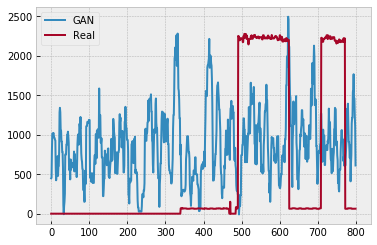

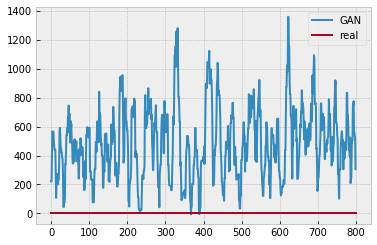

Batch_no: 500  Epoch: 100


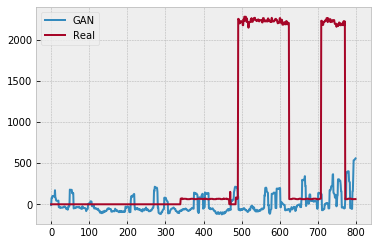

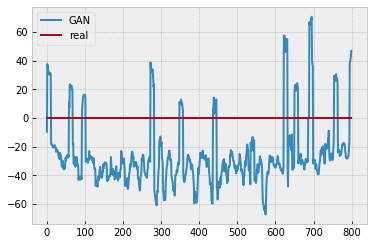

Batch_no: 1000  Epoch: 200


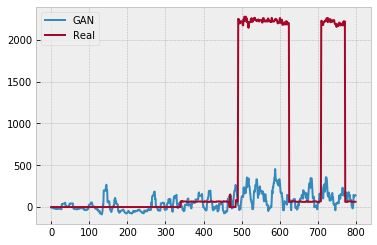

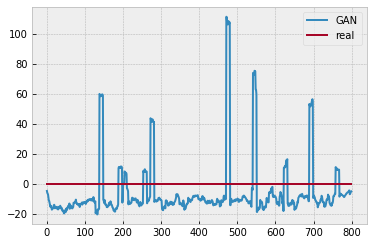

Batch_no: 1500  Epoch: 300


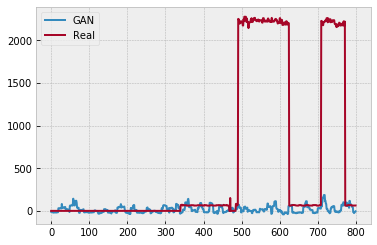

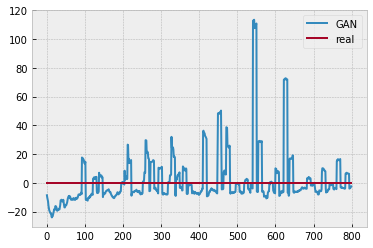

Batch_no: 2000  Epoch: 400


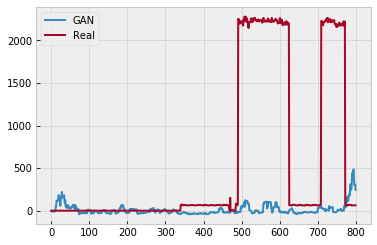

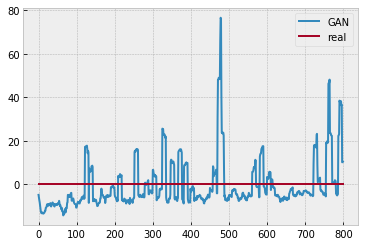

Batch_no: 2500  Epoch: 500


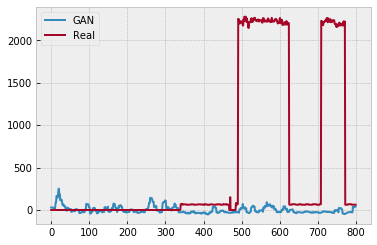

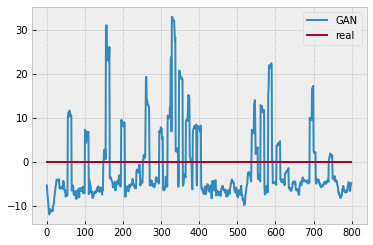

Batch_no: 3000  Epoch: 600


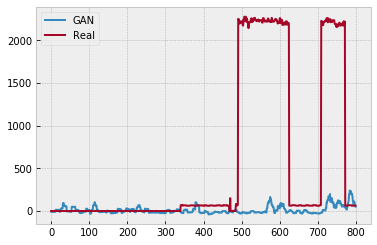

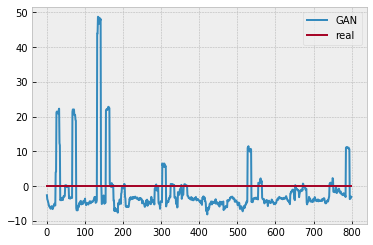

Batch_no: 3500  Epoch: 700


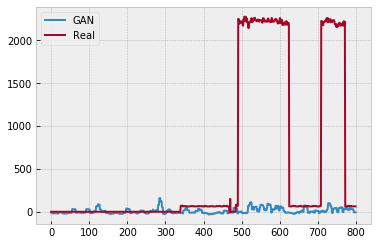

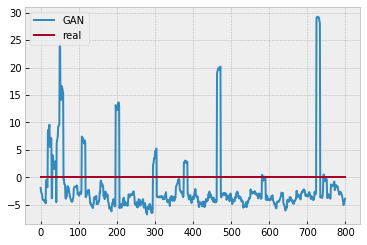

Batch_no: 4000  Epoch: 800


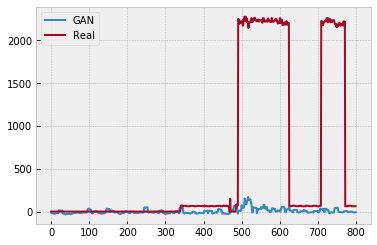

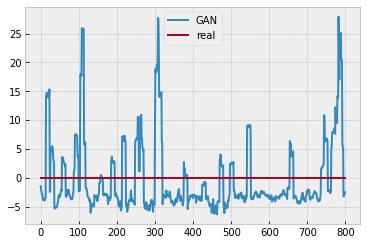

Batch_no: 4500  Epoch: 900


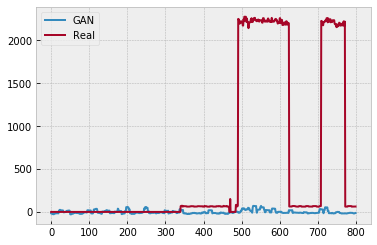

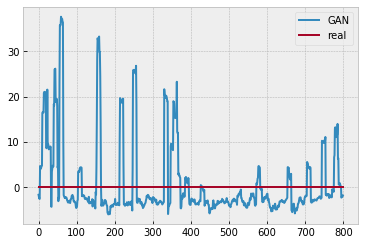

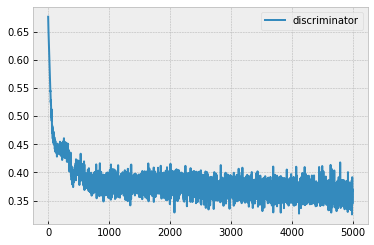

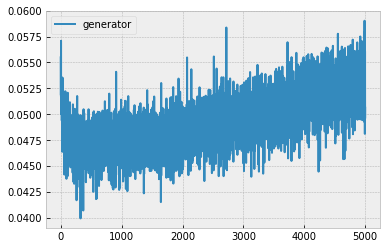

In [11]:
train_data_it=data_it()
dataloader=DataLoader(dataset=train_data_it,batch_size=batch_size,shuffle=True)


d_retrain=["d3","d4","d5"] #best choice



g_retrain=["g7"]




# generator.load_state_dict(checkpoint['g_state_dict'],strict=True)
# discriminator.load_state_dict(checkpoint['d_state_dict'],strict=True)

# for name, child in generator.named_children():
#     if name in g_retrain:
#         print(name + ' is unfrozen in generator')
#         for param in child.parameters():
#             param.requires_grad = True
#     else:
#         print(name + ' is frozen in generator')
#         for param in child.parameters():
#             param.requires_grad = False


#         #discriminator configuring
#         for name, child in discriminator.named_children():
#             if name in d_retrain:
#                 print(name + ' is unfrozen in discriminator ')
#                 for param in child.parameters():
#                     param.requires_grad = True
#             else:
#                 print(name + ' is frozen in discriminator')
#                 for param in child.parameters():
#                     param.requires_grad = False


for name, child in generator.named_children():
    if name in g_retrain:
        print(name + ' weights are initialized')
        torch.nn.init.xavier_uniform(child[0].weight.data)
    else:
        print(name + ' weights are kept')

for name, child in discriminator.named_children():
    if name in d_retrain:
        print(name + ' weights are initialized')
        torch.nn.init.xavier_uniform(child[0].weight.data)
    else:
        print(name + ' weights are kept')



# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))
# optimizer_G.state_dict()["param_groups"][0]["params"]





g_losses=[]
d_losses=[]



for epoch in range(n_epochs):
    g_running_loss=0.0
    d_running_loss=0.0
    for i, (aggregate, appliance) in enumerate(dataloader):

        #reshaping to fit the convolution layer
        aggregate_reshaped=aggregate.reshape(aggregate.shape[0],1,aggregate.shape[1])

        batch_size = appliance.shape[0]
        app=appliance[:,:]

        # Adversarial ground truths
        valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
        fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_aggregate_reshaped = Variable(aggregate_reshaped.type(FloatTensor))
        real_appliance = Variable(app.type(FloatTensor))
        real_aggregate= Variable(aggregate.type(FloatTensor))

        real_app_real_agg=torch.cat((real_appliance,real_aggregate),1)


        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()


        gen_appliance = generator(real_aggregate_reshaped)

# #subtracting the first output
#         if epoch==0 and i==0:
#             first_gen1=gen_appliance[0,:].detach()


#         first_gen=first_gen1.repeat(len(appliance),1)
#         gen_appliance=gen_appliance-first_gen



        gen_app_real_agg=torch.cat((gen_appliance,real_aggregate),1)

        validity,feat= discriminator(gen_app_real_agg)

        g_loss=feature_loss(feat, real_app_real_agg)
#         g_loss = adversarial_loss(validity, valid)

        g_loss.backward()
        optimizer_G.step()
        g_loss_1=g_loss.item()


#                 g_losses.append(g_loss.item())

########################################################################################################################
# # Generator second training round


        optimizer_G.zero_grad()

        gen_appliance = generator(real_aggregate_reshaped)



#         gen_appliance=gen_appliance-first_gen #subtract




        gen_app_real_agg=torch.cat((gen_appliance,real_aggregate),1)
        validity,feat = discriminator(gen_app_real_agg)
        g_loss = feature_loss(feat, real_app_real_agg)

#         g_loss = adversarial_loss(validity, valid)


        g_loss.backward()
        g_loss_2=g_loss.item()

        optimizer_G.step()


        # g_running_loss+=g_loss.item()
        #g_epoch_loss=g_running_loss/len(dataloader)        
        #g_losses.append(g_epoch_loss)

# Generator third training round

        optimizer_G.zero_grad()

        gen_appliance = generator(real_aggregate_reshaped)


#         gen_appliance=gen_appliance-first_gen #subtract

        gen_app_real_agg=torch.cat((gen_appliance,real_aggregate),1)

        validity,feat = discriminator(gen_app_real_agg)


        g_loss = feature_loss(feat, real_app_real_agg)
#         g_loss = adversarial_loss(validity, valid)

        g_loss.backward()
        optimizer_G.step()

        g_loss_3=g_loss.item()

        g_losses.append((g_loss_1+g_loss_2+g_loss_3)/3)


# ----------
#  Training
# ----------


        # ---------------------
        #  Train Discriminator
        # ---------------------


        optimizer_D.zero_grad()


        real_app_real_agg=torch.cat((appliance,aggregate),1)

        real_app_real_agg=Variable(real_app_real_agg.type(FloatTensor))

        validity_real,_ = discriminator(real_app_real_agg)
        d_real_loss = adversarial_loss(validity_real, valid)

        validity_fake,_ = discriminator(gen_app_real_agg.detach()) #detach
        d_fake_loss = adversarial_loss(validity_fake, fake)

        d_loss = (d_real_loss + d_fake_loss) / 2


        d_loss.backward()
        optimizer_D.step()


        d_losses.append(d_loss.item())

        ## end trining discrimnator

        batches_done = epoch * len(dataloader) + i
        #print("Epoch:",epoch,"Batch:",i,"of:",len(dataloader),"batches done:",batches_done)
        if batches_done % sample_interval == 0:
            print("Batch_no:",batches_done," Epoch:",epoch)
            sample_data(n_row=1, batches_done=batches_done)
plt.plot(d_losses,label="discriminator")
plt.legend()
plt.show()

plt.plot(g_losses,label="generator")
plt.legend()
plt.show()


#disaggregate
# house 1



# end house 1

# #house 5
# X_to_disaggregate=np.load("X_raw_house_5.npy") 
# Y_true=np.load("Y_raw_house_5.npy")
# X_to_disaggregate=X_to_disaggregate[::s][0:140000]
# Y_true=Y_true[::s][0:140000]
# # print(X_s.shape[0])
# plt.plot(Y_true)
# #end house 5



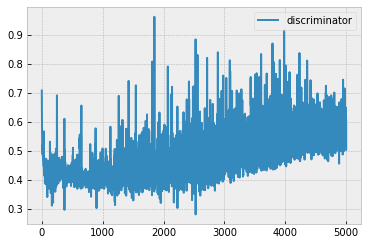

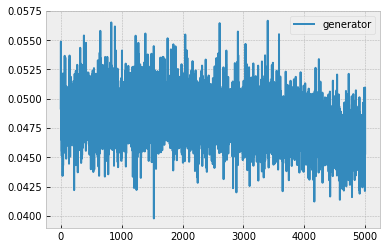

In [12]:
plt.plot(d_losses,label="discriminator")
plt.legend()
plt.show()

plt.plot(g_losses,label="generator")
plt.legend()
plt.show()


## Disaggregate

segmenting predictions...
0  of  119799
10000  of  119799
20000  of  119799
30000  of  119799
40000  of  119799
50000  of  119799
60000  of  119799
70000  of  119799
80000  of  119799
90000  of  119799
100000  of  119799
110000  of  119799
MAX are:  0.332934131736527 8.114823959642331 at step: 500


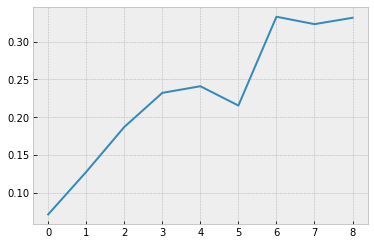

segmenting predictions...
0  of  119599
10000  of  119599
20000  of  119599
30000  of  119599
40000  of  119599
50000  of  119599
60000  of  119599
70000  of  119599
80000  of  119599
90000  of  119599
100000  of  119599
110000  of  119599
MAX are:  0.15886939571150097 9.089769125931877 at step: 600


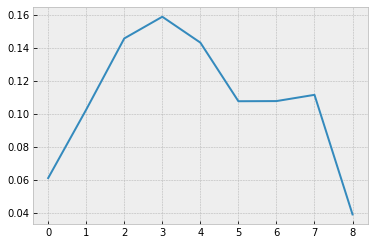

segmenting predictions...
0  of  119799
10000  of  119799
20000  of  119799
30000  of  119799
40000  of  119799
50000  of  119799
60000  of  119799
70000  of  119799
80000  of  119799
90000  of  119799
100000  of  119799
110000  of  119799
MAX are:  0.1777535441657579 9.044702993835001 at step: 700


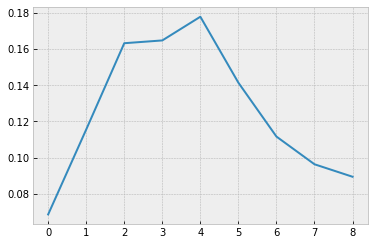

In [12]:
X_to_disaggregate=np.load("data/REFIT_house6_X_raw_test_DW.npy")[80000:]
Y_true=np.load("data/REFIT_house6_Y_raw_test_DW.npy")[80000:]

agg_len=X_to_disaggregate.shape[0]
w=sig_len
for step in range(500,800,100): #64 #32

    agg_segments=np.zeros((1,w))
    app_segments=np.zeros((1,w))



    i=0
    while i<=agg_len-w:
        agg_segment=X_to_disaggregate[i:i+w].reshape(1,-1)
        app_segment=Y_true[i:i+w].reshape(1,-1)
        agg_segments=np.concatenate((agg_segments,agg_segment),axis=0)
        app_segments=np.concatenate((app_segments,app_segment),axis=0)
        i+=step

    agg_segments=agg_segments[1:,:]    
    app_segments=app_segments[1:,:]    



    agg_segments_scaled=scale_agg.transform(agg_segments)
    agg_segments_scaled_reshaped=agg_segments_scaled.reshape(agg_segments_scaled.shape[0],1,agg_segments_scaled.shape[1])
    app_segments_scaled=scale_app.transform(app_segments)


    samples_from=0
    samples_to=int(len(agg_segments_scaled_reshaped))

    sub_agg_segments=agg_segments_scaled_reshaped[samples_from:samples_to,:]
    sub_app_true=app_segments_scaled[samples_from:samples_to,:]

    #sub_app_true=app_segments[samples_from:samples_to,:]
    gen_out=disaggregate(sub_agg_segments)#tensor generated

    disaggregated_appliance=np.array(gen_out.cpu().detach()) #numpy appliance generated
    disaggregated_appliance_inv=scale_app.inverse_transform(disaggregated_appliance)

    # sub_app_true_inv=scale_app.inverse_transform(sub_app_true) #app segments

    threshold=0
    disaggregated_appliance_inv[disaggregated_appliance_inv<=threshold] = 0
    sub_agg_segments[sub_agg_segments<=threshold] = 0


    disaggregation_confidence=confidence(appliance=gen_out,aggregate=sub_agg_segments[:,0,:])
    disaggregation_confidence.shape


    indecis_matrix=np.zeros(sub_app_true.shape)
    indecis_matrix.shape

    d=np.array(disaggregation_confidence.cpu().detach())
    confidence_repeated=np.repeat(d,disaggregated_appliance.shape[1],axis=1)


    k=0
    for i in range(len(indecis_matrix)):
        indecis_matrix[i,:]=np.arange(k,k+w,dtype = 'int')
        k+=step
    indecis_matrix=indecis_matrix.reshape(1,-1).astype("int")
    disaggregated_appliance_flat=disaggregated_appliance_inv.reshape(1,-1)
    real_appliance_flat=app_segments.reshape(1,-1)
    confidence_repeated_flat=confidence_repeated.reshape(1,-1)


    print("segmenting predictions...")

    pred_dict={}
    confidence_dict={}
    real_dict={}

    for j in range(np.max(indecis_matrix)):
        if j % 10000 == 0:
            print(j," of ", np.max(indecis_matrix))
        a=np.where(indecis_matrix==j)[1]
        pred_dict[j]=disaggregated_appliance_flat[0,a]
        confidence_dict[j]=confidence_repeated_flat[0,a]
        real_dict[j]=real_appliance_flat[0,a]




    from scipy import stats
    threshold=0

    pred_clustered=[] 
    true_app_list=[]
    for key in pred_dict.keys():
        p=pred_dict[key]
        conf=confidence_dict[key]
    #     p[p<=threshold]=0  # thresholding
    #     pred_clustered.append(p.mean())

        pred_clustered.append(p[np.argmax(conf)])
    #     pred_clustered.append(np.percentile(pred_dict[key],80))
        tr=real_dict[key]
    #     tr[tr<=threshold]=0

        true_app_list.append(tr[0])



    shift=0    
    pred_clustered_shifted=np.zeros(len(pred_clustered))
    pred_clustered_shifted[shift:len(pred_clustered)]=pred_clustered[0:len(pred_clustered)-shift]
    # pred_clustered_shifted=pred_clustered_shifted-np.ones(pred_clustered_shifted.shape)*500
    # pred_clustered_shifted[pred_clustered_shifted <=0] = 0


    predictions=np.asarray(pred_clustered_shifted)[0:int(len(pred_clustered_shifted))]
    appliance_true=np.asarray(Y_true[0:int(len(pred_clustered_shifted))])



    pts=10
    predictions_smoothed=smooth(predictions,box_pts=pts)
    appliance_true_smoothed=smooth(appliance_true,box_pts=pts)




    f1=[]
    mae=[]
    for i in range(10,100,10):
    #     print(i)
        _,_,f,_=classification_metrics(predictions_smoothed,appliance_true_smoothed,thresh=i)
        f1.append(f)
        _,mae1=energy_metrics(predictions_smoothed,appliance_true,thresh=i)
        mae.append(mae1)

#     print("+++++++++++++++++++")
#     # print(str(g_retrain))
#     print("Smoothed..")
#     recall2,precision2,F12,accuracy2=classification_metrics(predictions_smoothed,appliance_true_smoothed,thresh=1)
#     print("recall= %f, precision= %f, F1= %f, accuracy= %f" %(recall2,precision2,F12,accuracy2))

#     RE2,MAE2=energy_metrics(predictions_smoothed,appliance_true_smoothed,thresh=1)
#     print("RE=%f, MAE= %f"%(RE2,MAE2))
#     # performance1[str(g_retrain)]=[F12,MAE2,RE2]

    print("=============================================================")


    print("MAX are: ", max(f1),mae[f1.index(max(f1))],"at step:",step)

    plt.plot(f1)
    plt.show()

#     plt.plot(mae)
#     plt.show()

# f.close()
# plt.plot(predictions_smoothed[11000:15000])
# plt.plot(appliance_true_smoothed[11000:15000])
# plt.show()
# portion=int(portion+15*35)



In [ ]:


X_to_disaggregate=np.load("data/REFIT_house6_X_raw_test_DW.npy")[80000:]
Y_true=np.load("data/REFIT_house6_Y_raw_test_DW.npy")[80000:]

agg_len=X_to_disaggregate.shape[0]
w=sig_len
step=int(5) #64 #32

agg_segments=np.zeros((1,w))
app_segments=np.zeros((1,w))



i=0
while i<=agg_len-w:
    agg_segment=X_to_disaggregate[i:i+w].reshape(1,-1)
    app_segment=Y_true[i:i+w].reshape(1,-1)
    agg_segments=np.concatenate((agg_segments,agg_segment),axis=0)
    app_segments=np.concatenate((app_segments,app_segment),axis=0)
    i+=step

agg_segments=agg_segments[1:,:]    
app_segments=app_segments[1:,:]    



agg_segments_scaled=scale_agg.transform(agg_segments)
agg_segments_scaled_reshaped=agg_segments_scaled.reshape(agg_segments_scaled.shape[0],1,agg_segments_scaled.shape[1])
app_segments_scaled=scale_app.transform(app_segments)


samples_from=0
samples_to=int(len(agg_segments_scaled_reshaped))

sub_agg_segments=agg_segments_scaled_reshaped[samples_from:samples_to,:]
sub_app_true=app_segments_scaled[samples_from:samples_to,:]

#sub_app_true=app_segments[samples_from:samples_to,:]
gen_out=disaggregate(sub_agg_segments)#tensor generated

disaggregated_appliance=np.array(gen_out.cpu().detach()) #numpy appliance generated
disaggregated_appliance_inv=scale_app.inverse_transform(disaggregated_appliance)

# sub_app_true_inv=scale_app.inverse_transform(sub_app_true) #app segments

threshold=0
disaggregated_appliance_inv[disaggregated_appliance_inv<=threshold] = 0
sub_agg_segments[sub_agg_segments<=threshold] = 0


disaggregation_confidence=confidence(appliance=gen_out,aggregate=sub_agg_segments[:,0,:])
disaggregation_confidence.shape


indecis_matrix=np.zeros(sub_app_true.shape)
indecis_matrix.shape

d=np.array(disaggregation_confidence.cpu().detach())
confidence_repeated=np.repeat(d,disaggregated_appliance.shape[1],axis=1)


k=0
for i in range(len(indecis_matrix)):
    indecis_matrix[i,:]=np.arange(k,k+w,dtype = 'int')
    k+=step
indecis_matrix=indecis_matrix.reshape(1,-1).astype("int")
disaggregated_appliance_flat=disaggregated_appliance_inv.reshape(1,-1)
real_appliance_flat=app_segments.reshape(1,-1)
confidence_repeated_flat=confidence_repeated.reshape(1,-1)


print("segmenting predictions...")

pred_dict={}
confidence_dict={}
real_dict={}

for j in range(np.max(indecis_matrix)):
    if j % 5000 == 0:
        print(j," of ", np.max(indecis_matrix))
    a=np.where(indecis_matrix==j)[1]
    pred_dict[j]=disaggregated_appliance_flat[0,a]
    confidence_dict[j]=confidence_repeated_flat[0,a]
    real_dict[j]=real_appliance_flat[0,a]




from scipy import stats
threshold=0

pred_clustered=[] 
true_app_list=[]
for key in pred_dict.keys():
    p=pred_dict[key]
    conf=confidence_dict[key]
#     p[p<=threshold]=0  # thresholding
#     pred_clustered.append(p.mean())

    pred_clustered.append(p[np.argmax(conf)])
#     pred_clustered.append(np.percentile(pred_dict[key],80))
    tr=real_dict[key]
#     tr[tr<=threshold]=0

    true_app_list.append(tr[0])



f1=[]
mae=[]
for i in range(0,1200,10):
#     print(i)
    _,_,f,_=classification_metrics(predictions_smoothed,appliance_true_smoothed,thresh=i)
    f1.append(f)
    _,mae1=energy_metrics(predictions_smoothed,appliance_true_smoothed,thresh=i)
    mae.append(mae1)



print(max(f1),mae[f1.index(max(f1))])

plt.plot(f1)
plt.show()

plt.plot(mae)
plt.show()


In [ ]:


shift=0    
pred_clustered_shifted=np.zeros(len(pred_clustered))
pred_clustered_shifted[shift:len(pred_clustered)]=pred_clustered[0:len(pred_clustered)-shift]
# pred_clustered_shifted=pred_clustered_shifted-np.ones(pred_clustered_shifted.shape)*500
# pred_clustered_shifted[pred_clustered_shifted <=0] = 0


predictions=np.asarray(pred_clustered_shifted)[0:int(len(pred_clustered_shifted))]
appliance_true=np.asarray(Y_true[0:int(len(pred_clustered_shifted))])


predictions_smoothed=smooth(predictions,box_pts=10)
appliance_true_smoothed=smooth(appliance_true,box_pts=10)#(appliance_true[:,0],box_pts=10)

print("+++++++++++++++++++")
# print(str(g_retrain))
print("Smoothed..")
recall2,precision2,F12,accuracy2=classification_metrics(predictions_smoothed,appliance_true_smoothed,thresh=50)
print("recall= %f, precision= %f, F1= %f, accuracy= %f" %(recall2,precision2,F12,accuracy2))

RE2,MAE2=energy_metrics(predictions_smoothed,appliance_true_smoothed,thresh=50)
print("RE=%f, MAE= %f"%(RE2,MAE2))
# performance1[str(g_retrain)]=[F12,MAE2,RE2]

print("=============================================================")


with open('Perf_M4.txt', 'a') as f:
    f.write("   F1:")
    f.write(str([F12]))
    f.write("   MAE:")
    f.write(str([MAE2]))
    f.write("\n\n")
# f.close()
# plt.plot(predictions_smoothed[11000:15000])
# plt.plot(appliance_true_smoothed[11000:15000])
# plt.show()
# portion=int(portion+15*35)



In [ ]:
plt.plot(predictions_smoothed)
plt.plot(appliance_true_smoothed)
plt.show()

plt.plot(predictions_smoothed[2500:5000])
plt.plot(appliance_true[2500:5000])
plt.show()

In [ ]:

X_to_disaggregate=np.load("data/REFIT_house2_X_raw_test_DW.npy")#[0:2000]
Y_true=np.load("data/REFIT_house2_Y_raw_test_DW.npy")#[0:2000]

In [ ]:
plt.plot(predictions_smoothed)
plt.plot(appliance_true_smoothed)
plt.show()

# plt.plot(predictions_smoothed)
plt.plot(Y_true[6500:7500])
plt.show()

In [ ]:


    shift=0    
    pred_clustered_shifted=np.zeros(len(pred_clustered))
    pred_clustered_shifted[shift:len(pred_clustered)]=pred_clustered[0:len(pred_clustered)-shift]
    # pred_clustered_shifted=pred_clustered_shifted-np.ones(pred_clustered_shifted.shape)*500
    # pred_clustered_shifted[pred_clustered_shifted <=0] = 0


    predictions=np.asarray(pred_clustered_shifted)[0:int(len(pred_clustered_shifted))]
    appliance_true=np.asarray(Y_true[0:int(len(pred_clustered_shifted))])


    predictions_smoothed=smooth(predictions,box_pts=10)
    appliance_true_smoothed=smooth(appliance_true[:,0],box_pts=10)

    print("+++++++++++++++++++")
    print(str(g_retrain))
    print("Smoothed..")
    recall2,precision2,F12,accuracy2=classification_metrics(predictions_smoothed,appliance_true_smoothed,thresh=50)
    print("recall= %f, precision= %f, F1= %f, accuracy= %f" %(recall2,precision2,F12,accuracy2))

    RE2,MAE2=energy_metrics(predictions_smoothed,appliance_true_smoothed,thresh=50)
    print("RE=%f, MAE= %f"%(RE2,MAE2))

    performance1[str(g_retrain)]=[F12,MAE2,RE2]

    print("=============================================================")


    with open('perf_On_UKDALE_WM_data_amount.txt', 'a') as f:
        f.write(str(g_retrain))
        f.write(str(d_retrain))
        f.write(portion)
        f.write("   F1:")
        f.write(str([F12]))
        f.write("\n\n")
    f.close()
    portion=int(portion+15*35)

